<a href="https://colab.research.google.com/github/colbrydi/Scientific_Image_Understanding/blob/master/06_Homography-in-class-assignment.ipynb"><img src="https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667"></a>

# In-Class Assignment: Homography

<img src="https://lh4.googleusercontent.com/y94B_GtPD3FiOVo9L9LblKxTHp5zgsSlCTddxq-27iSPFnPs5mtG4ZqBRBsVCfK9-dxEWc0sIw=w740" width="100%">



### Agenda for today's class:

1. [ Homography Example](#-Homography-Example)
2. [Useful Tools for Image and Video Manipulation:](#Useful-Tools-for-Image-and-Video-Manipulation:)
3. [Video Registration](#Video-Registration)





---
<a name=-Homography-Example></a>
# 1.  Homography Example



The following code downloads three images. We would like to pick points and evaluate the homography transform similar to the pre-class assignment.  

This example uses some experimental code designed to enable the selecting of points inside an image.  To get this code to work you will need to install the ```mpld3``` library and add the installation path to the notebook. 

**&#9989; DO THIS:** Remove the comment (#) from the following line of code and run the cell to install mpld3.  You only need to do this once so make sure you put the comment back in:


In [1]:
## Import all necessary packages
%matplotlib inline
import scipy.sparse as sparse #this helps to speed up the algorithms, but you will not use it. 
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing(use_unicode=True)


In [2]:
#The following code snip-it downloads the files from internet and saves tnhem to your local directory.
from urllib.request import urlopen, urlretrieve
import imageio

#Load a list of images
ImageList = [('checkers', 'https://goo.gl/j2SFnL'),
             ('sparty','https://cdn.shopify.com/s/files/1/1058/4992/products/MSU-Gruffy-Sparty-Sticker-550_620x.jpg?v=1525615105'),
             ('billboard', 'https://lh4.googleusercontent.com/OA8Et4hB-vpuYTKt86gk9i_Or1ptNbxtuYnR-7vujPVuVx6m30wXoVE3_d5fG_xDYAxUmDxOUw=w600'),
             ('banner', 'https://lh4.googleusercontent.com/aORranhBKm_pVs-Mg_pkyY1e8ujLh_7Y671d2BjNrWPiagBqktcJvD34ZHgUQrgbFAj4xOcf0Q=w740')
            ]

for name, url in ImageList:
    file = name+'.png'
    urlretrieve(url, file);
    exec(name + " = imageio.imread(file)")

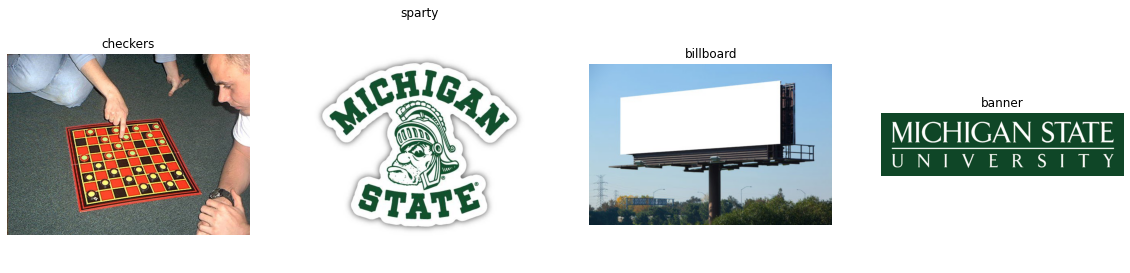

In [3]:
#show all of the images used in this assignment
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(20,10))
ax1.imshow(checkers);
ax1.set_title('checkers')
ax1.axis('off');
ax2.imshow(sparty);
ax2.set_title('sparty')
ax2.axis('off');
ax3.imshow(billboard);
ax3.set_title('billboard')
ax3.axis('off');
ax4.imshow(banner);
ax4.set_title('banner')
ax4.axis('off');


# Part 1: Homography Example

Making a homography projection can be split into three steps:

- Step 1: Define common points in two images
- Step 2: Computing the Homography Transform ($H$)
- Step 3: Warping the image from one coordinate system to the other


### Step 1: Define common points in two images

Consider the following example with the "checkers" image.  This code will transform just the checker board from the floor into a square image.  

Key to making this work is to have a set of commonly defined points on each image.  For simplicity we used all of the corner points of the checker board and the "midpoints" on the edge of the board between the corner points and the center of the board.  All points are recording in "image coordinates" with the x=column and y = row. I was unable to find an easy-to-use python program to let you pick the points so the points are provided for you.  The trick is to find a transform that converts points in the image on the left hand coordinate system to points in the image on the right hand side coordinate system. 

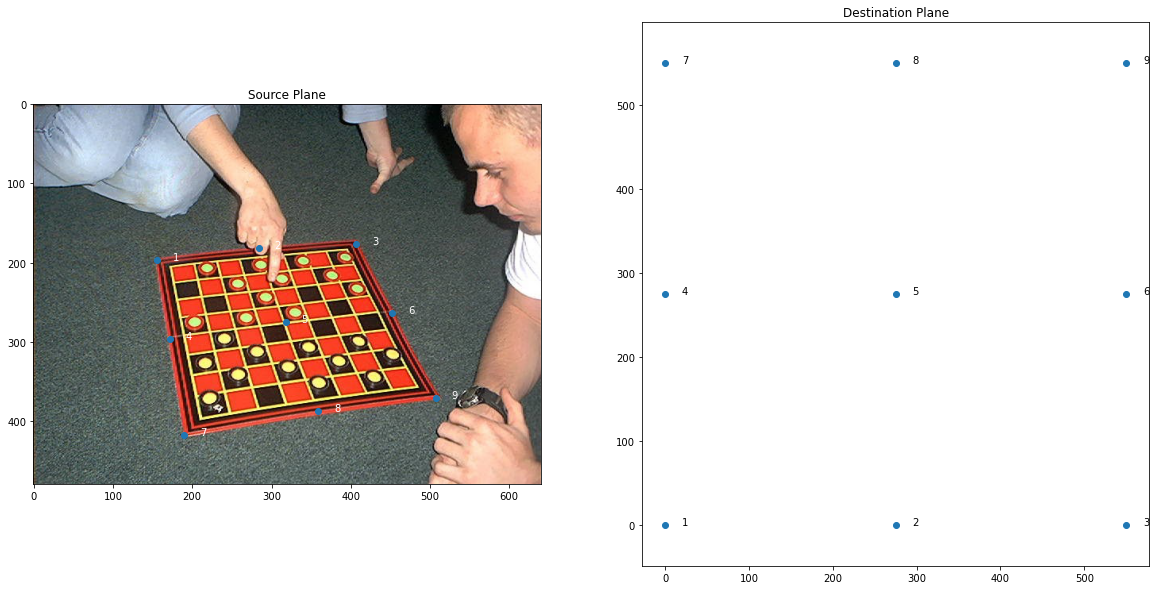

In [4]:
#Points in source image coordinate system
checker_pts = np.array([[156, 197],[284, 181],[407, 177],[172, 296],[318, 275],[452, 264],[190, 418],[359, 387],[507, 371]])

width=550
height=550

#Points in desitnation coordinate system
square_points = np.array([[0, width/2, width, 0, width/2, width, 0, width/2, width,], 
                          [0, 0, 0, height/2, height/2, height/2, height, height, height]]).T


#show original points next to transformed points
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.imshow(checkers)
ax1.scatter(checker_pts[:,0],checker_pts[:,1])
#Add numbers
for i in range(checker_pts.shape[0]):
    ax1.annotate(str(i+1), (checker_pts[i,0]+20,checker_pts[i,1]), color='white');
ax1.set_title('Source Plane')

ax2.scatter(square_points[:,0],square_points[:,1])
#Add numbers
for i in range(square_points.shape[0]):
    ax2.annotate(str(i+1), (square_points[i,0]+20,square_points[i,1]));
ax2.set_title('Destination Plane')
ax2.axis('equal');

### Step 2: Computing the Homography Transform ($H$)
The ```skimage``` library has a built in formula to calculate the transform  (```tform```) from the left image to the right image. This transform can be calculate using the coordinates for the points in the source image and the coordinates for the points in the destination image as follows:

In [5]:
#Calculate Homography Transformation
from skimage import transform

#Magic function to calculate projective transform from the source to the destination
tform = transform.ProjectiveTransform()
tform.estimate(square_points, checker_pts)

True

At it's core, the ```tform``` variable is just a $3 \times 3$ transforms matrix with the values of the matrix stored in the params variable.  The following code converts the matrix into a ```numpy``` array which is then viewed as a ```sympy``` matrix:

In [6]:
H = tform.params
sym.Matrix(H)

⎡ 0.561008085278872    -0.0103310210644121   166.148976925281⎤
⎢                                                            ⎥
⎢-0.0107310569934908    0.249432814139562    210.660404335667⎥
⎢                                                            ⎥
⎣0.000164767252642636  -0.00043777357835048  1.07507673956966⎦

**Visualization Trick**: I sometimes find it hard to read large floating point numbers.  To make them more readable I like to round them off. The following code rounds to the nearest 1/100 place.

In [7]:
sym.Matrix(np.round(H*100)/100)

⎡0.56   -0.01  166.15⎤
⎢                    ⎥
⎢-0.01  0.25   210.66⎥
⎢                    ⎥
⎣ 0.0    0.0    1.08 ⎦

### Step 3: Warping the image from one coordinate system to the other

Now we use the ```transform.warp``` function to create a new image in the left hand coordinate system using the right hand image pixel values and display the two image side-by-side:

In [8]:
#warp takes transform and makes a new image
square_image = transform.warp(checkers, tform, output_shape=(width,height)) 

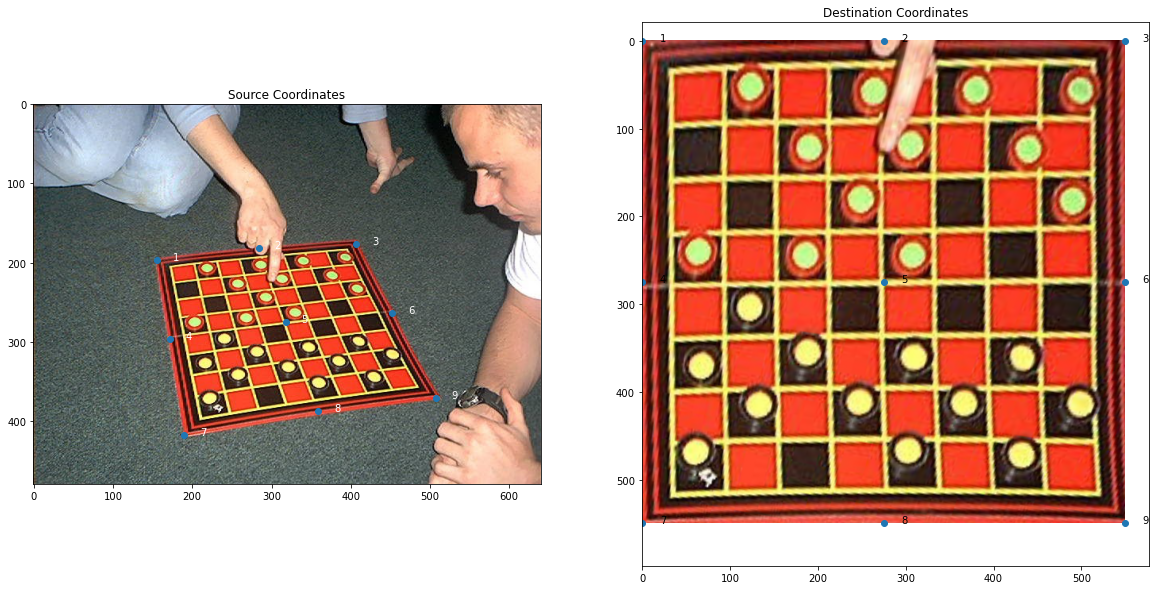

In [9]:
#show original image next to transformed image

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.imshow(checkers)
ax1.scatter(checker_pts[:,0],checker_pts[:,1])
#Add numbers
for i in range(checker_pts.shape[0]):
    ax1.annotate(str(i+1), (checker_pts[i,0]+20,checker_pts[i,1]), color='white');
ax1.set_title('Source Coordinates')

ax2.imshow(square_image)
ax2.scatter(square_points[:,0],square_points[:,1])
#Add numbers
for i in range(square_points.shape[0]):
    ax2.annotate(str(i+1), (square_points[i,0]+20,square_points[i,1]));
ax2.set_title('Destination Coordinates')
ax2.axis('equal');

## Inverse Homography

Lets do the same thing again but this time we will use the Sparty Image and move it on top of the checkerboard image.

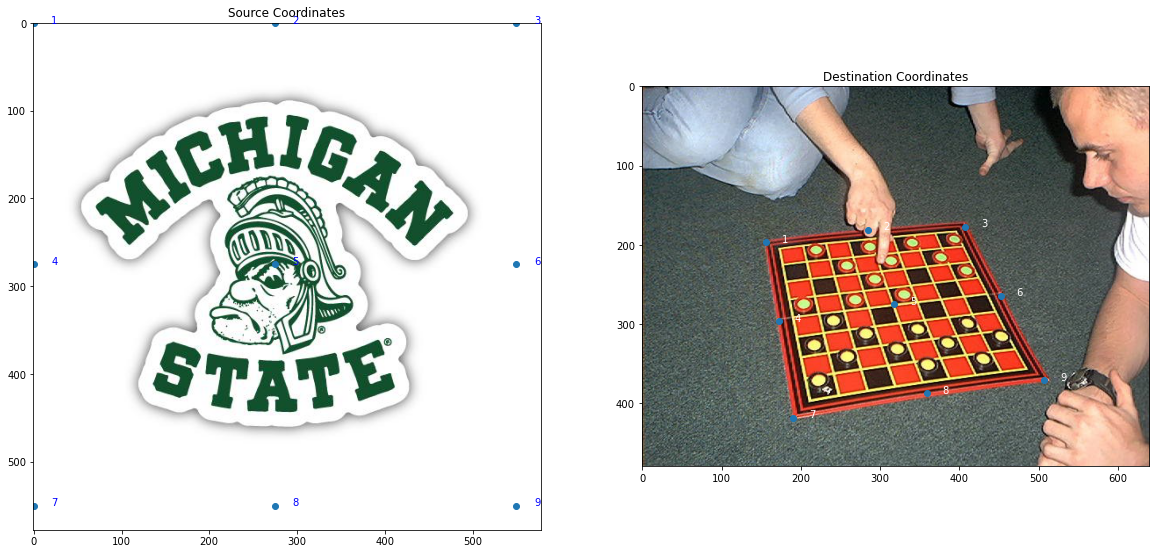

In [10]:
height = sparty.shape[0]
width = sparty.shape[1]

sparty_pts = np.array([[0, height/2, height, 0, height/2, height, 0, height/2, height,], 
                       [0, 0, 0, width/2, width/2, width/2, width, width, width]]).T


#show original points next to transformed points
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.imshow(sparty)
ax1.scatter(sparty_pts[:,0],sparty_pts[:,1])
#Add numbers
for i in range(sparty_pts.shape[0]):
    ax1.annotate(str(i+1), (sparty_pts[i,0]+20,sparty_pts[i,1]), color='blue');
ax1.set_title('Source Coordinates')

ax2.imshow(checkers)
ax2.scatter(checker_pts[:,0],checker_pts[:,1])
#Add numbers
for i in range(checker_pts.shape[0]):
    ax2.annotate(str(i+1), (checker_pts[i,0]+20,checker_pts[i,1]),color='white');
ax2.set_title('Destination Coordinates');



Although we could use the ```estimate``` function again.  Lets see what happens if we just calculate the Transformation matrix using the inverse of the $H$ matrix calculated earlier. 

&#9989; **<font color=red>DO THIS:</font>** Calculate the inverse of the ```H``` and call this new matrix ```H_inv```:

In [11]:
H_inv = np.linalg.inv(H)

Now we can plug ```H_inv``` into our ```tform``` variable and warp the ```sparty``` image into the ```checkers``` image using the following code:
    

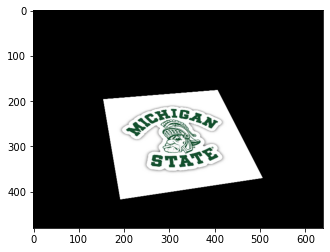

In [12]:
tform.params = H_inv

#warp takes transform and makes a new image
warped = transform.warp(sparty, tform, output_shape=checkers.shape)

plt.imshow(warped)

To see our final product lets "add" the warped with the original checkers image.  This is a little tricky so use the following function:

In [13]:
def addImages(original, warped):
    
    if original.shape != warped.shape:
        raise Exception('Size Missmatch Error - Input images should be the same size')
    
    if (len(original.shape) != 3):
        raise Exception('Image Type error - Images should be in RGB format')
            
    red_src = np.array(original[:,:,0])
    green_src = np.array(original[:,:,1])
    blue_src = np.array(original[:,:,2])

    if (np.max(warped) == 1):
        scale = 255.0
        
    red_dst = warped[:,:,0]*scale
    green_dst = warped[:,:,1]*scale
    blue_dst = warped[:,:,2]*scale

    image_mask = (np.sum(warped, axis=2) == 0)
    
    red_new = red_src*image_mask
    green_new = green_src*image_mask
    blue_new = blue_src*image_mask
    
    im_new = np.zeros(original.shape)
    im_new[:,:,0] = (red_new + red_dst)/255
    im_new[:,:,1] = (green_new + green_dst)/255
    im_new[:,:,2] = (blue_new + blue_dst)/255
    
    return im_new

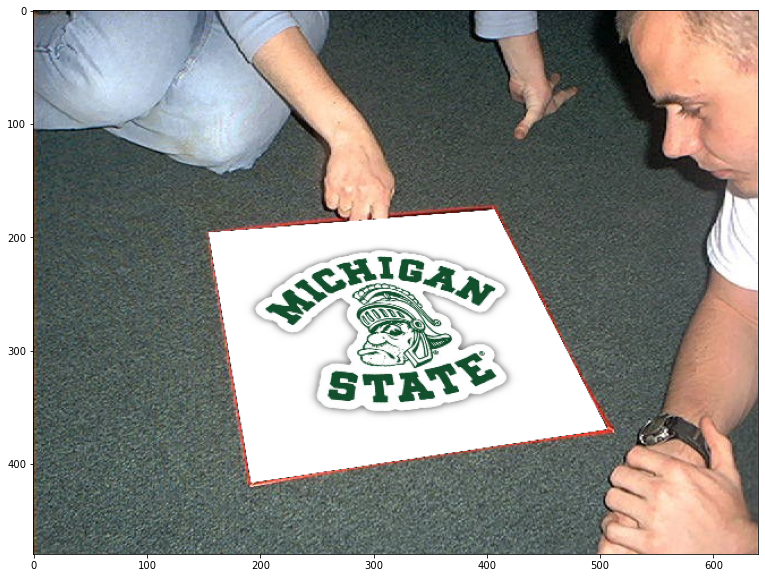

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(addImages(checkers, warped));

&#9989; **<font color=red>QUESTION:</font>**  Why doesn't the ```sparty``` image cover the entire checkerboard?  

Put your answer here

&#9989; **<font color=red>DO THIS:</font>**  Modify the above example code to fix it and make the sparty image cover the entire checkerboard.

## Projecting onto a billboard

Now lets review what you have learned in Examples 2 and 3. Consider the following banner/billboard example:

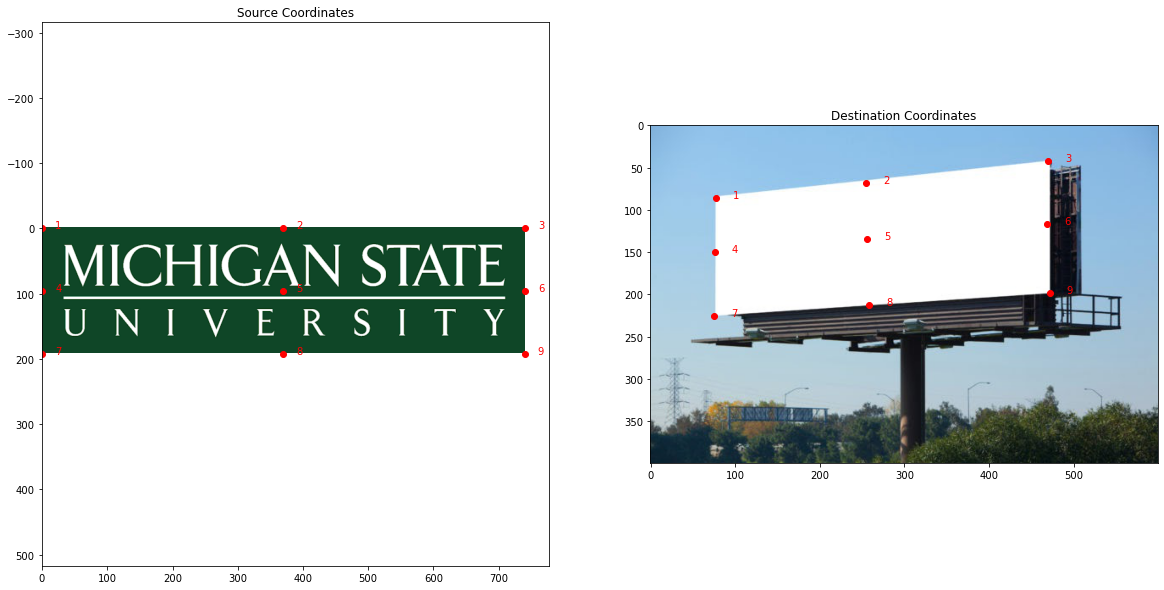

In [15]:

billboard_pts = np.array([[ 77, 255, 470,  76, 256, 469,  75, 258, 472], 
                          [ 86,  68,  42, 150, 135, 117, 225, 212, 198]]).T


height = banner.shape[0]
width = banner.shape[1]

banner_pts = np.array([[0, width/2, width, 0, width/2, width, 0, width/2, width,], 
                       [0, 0, 0, height/2, height/2, height/2, height, height, height]]).T

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.imshow(banner)
ax1.scatter(banner_pts[:,0],banner_pts[:,1],color='red')
#Add numbers
for i in range(banner_pts.shape[0]):
    ax1.annotate(str(i+1), (banner_pts[i,0]+20,banner_pts[i,1]), color='red');
ax1.set_title('Source Coordinates')
ax1.axis('equal');

ax2.imshow(billboard)
ax2.scatter(billboard_pts[:,0],billboard_pts[:,1],color='red')
#Add numbers
for i in range(billboard_pts.shape[0]):
    ax2.annotate(str(i+1), (billboard_pts[i,0]+20,billboard_pts[i,1]), color='red');
ax2.set_title('Destination Coordinates');



&#9989; **<font color=red>DO THIS:</font>**  Write a program to warp the MSU banner onto the billboard.  

In [16]:
# put your code here

---

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

---